# Data Transformation

This notebook focuses on transforming cleaned data into analysis-ready features.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
patients_cleaned = pd.read_csv("data/patients_cleaned.csv")

In [3]:
patients_cleaned.head()

,patient_id,age,admission_date,discharge_date,gender,weight,height,blood_pressure,admission_unit,albumin_g_dl
0,1,39.0,2023-01-05,2023-01-10,f,78.0,184.0,130.0,Surgery,1.00
1,2,60.0,2023-02-11,2023-02-20,m,55.0,180.0,90.0,Cardiol.,4.26
2,4,50.0,2023-03-20,2023-03-25,f,70.0,179.0,110.0,Intensive Care U.,3.10
3,10,45.0,2023-07-05,2023-07-15,m,90.0,165.0,80.0,Neurology,3.10
4,12,90.0,2023-08-10,2023-08-20,female,45.0,170.0,60.0,Intensive Care U.,4.26


In [4]:
#patients_cleaned.info()

## 1 Checking categorical variables

- Categorical variables often contain multiple spellings or encodings for the same concept. We need to standardize these.
- Here we focus on the `gender` column:
    - First, we inspect unique values and their counts.
    - Then we replace inconsistent entries with a standard value.
- Casting to `category` dtype can reduce memory and make intent explicit.

In [5]:
# Show number of unique categories and their counts
patients_cleaned['gender'].value_counts(dropna=False)

gender
m         9
male      9
f         6
female    2
Name: count, dtype: int64

In [6]:
# Correct inconsistent entries - f -> female, m -> male
patients_cleaned['gender'] = patients_cleaned['gender'].replace('f', 'female')
patients_cleaned['gender'] = patients_cleaned['gender'].replace('m', 'male')

In [7]:
patients_cleaned['gender'].value_counts(dropna=False)

gender
male      18
female     8
Name: count, dtype: int64

In [8]:
# visualize gender distribution

### Check admission_unit for unique values

In [9]:
# Check unique values in admission_unit
patients_cleaned['admission_unit'].value_counts(dropna=False)

admission_unit
Intensive Care U.    5
Psychiatry           5
Cardiol.             3
Surgery              2
Neurology            2
Orthopedics          2
Pediatrics           2
Emergency Room       2
General Medicine     2
Oncology             1
Name: count, dtype: int64

### Rename inconsistent entries

In [10]:
# Standardize admission_unit entries
patients_cleaned['admission_unit'] = patients_cleaned['admission_unit'].replace({'Emergency Room': 'ER', 'Intensive Care U.': 'ICU', 'Cardiol.': 'Cardiology'})

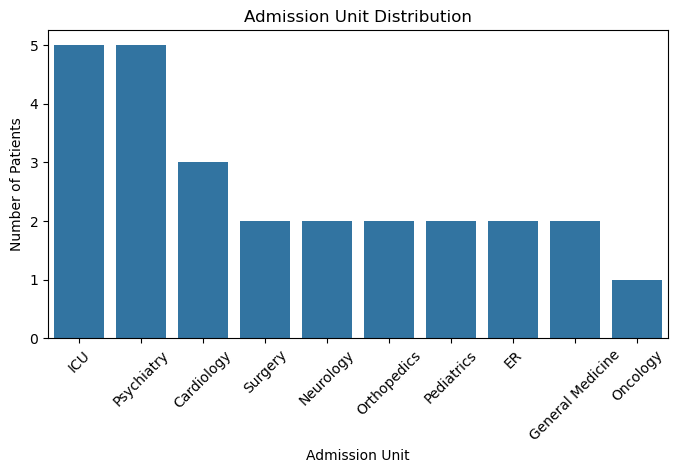

In [11]:
# visualize admission_unit distribution

plt.figure(figsize=(8,4))
sns.countplot(data=patients_cleaned, x='admission_unit', order=patients_cleaned['admission_unit'].value_counts().index)
plt.title('Admission Unit Distribution')
plt.ylabel('Number of Patients')
plt.xlabel('Admission Unit')
plt.xticks(rotation=45)
plt.show()

## 2 Encoding categorical variables for modeling

- Many models require numeric inputs. `pd.get_dummies()` creates one-hot encoded columns for categorical variables.
- For high-cardinality categorical features you may want alternative encoding strategies (target encoding, embedding, hashing).

### One-hot encoding for 'gender'

In [12]:
# One-hot encode gender
patients_cleaned = pd.get_dummies(patients_cleaned, columns=['gender'], drop_first=True)

### Label Encoding for 'admission_unit'

- For admission_unit with multiple categories, we use label encoding to convert categories to integer codes.
- This is simple but imposes an ordinal relationship. For non-ordinal categories, one-hot encoding is often preferred.
- Here we demonstrate label encoding for variety.
- First convert to 'category' dtype, then use `.cat.codes` to get integer codes.
- Note: In practice, use sklearn's LabelEncoder or OrdinalEncoder for more control.

In [13]:
# Convert admission_unit to 'category' dtype
patients_cleaned['admission_unit_encoded'] = patients_cleaned['admission_unit'].astype('category')

# Label encode admission_unit
patients_cleaned['admission_unit_encoded'] = patients_cleaned['admission_unit_encoded'].cat.codes

In [14]:
patients_cleaned.head()

,patient_id,age,admission_date,discharge_date,weight,height,blood_pressure,admission_unit,albumin_g_dl,gender_male,admission_unit_encoded
0,1,39.0,2023-01-05,2023-01-10,78.0,184.0,130.0,Surgery,1.00,False,9
1,2,60.0,2023-02-11,2023-02-20,55.0,180.0,90.0,Cardiology,4.26,True,0
2,4,50.0,2023-03-20,2023-03-25,70.0,179.0,110.0,ICU,3.10,False,3
3,10,45.0,2023-07-05,2023-07-15,90.0,165.0,80.0,Neurology,3.10,True,4
4,12,90.0,2023-08-10,2023-08-20,45.0,170.0,60.0,ICU,4.26,False,3


## 3 Feature engineering - creating new features from existing ones

- BMI (Body Mass Index) is a common clinical feature derived from weight and height.
- BMI = weight (kg) / (height (m))2
- In our dataset height is in cm, so it needs to be converted before calculation.


In [15]:
# Compute BMI (height in cm -> convert to meters)
patients_cleaned['BMI'] = patients_cleaned['weight'] / (patients_cleaned['height']/100)**2

In [16]:
# Inspect BMI distribution and missingness
patients_cleaned['BMI'].describe()

count    26.000000
mean     25.087716
std       6.945768
min      14.527376
25%      21.232993
50%      22.505044
75%      29.602852
max      40.562466
Name: BMI, dtype: float64

## Save transformed data

In [17]:
# Save the transformed dataset
patients_cleaned.to_csv("data/patients_transformed.csv", index=False)

## 4 Scaling and standardization

- Many ML algorithms assume features are on similar scales
- `MinMaxScaler` rescales to [0,1]
- `StandardScaler` centers to mean=0 and std=1

We demonstrate both for different use cases.

### Method 1: Min-Max Scaling

In [18]:
# Demonstrate MinMax scaling for 'age' and Standard scaling for blood pressure
minmax = MinMaxScaler()
patients_cleaned['age_minmax'] = minmax.fit_transform(patients_cleaned[['age']])

### Method 2: Standardization

In [19]:
std = StandardScaler()
patients_cleaned['bp_std'] = std.fit_transform(patients_cleaned[['blood_pressure']])

In [20]:
patients_cleaned.head()

,patient_id,age,admission_date,discharge_date,weight,height,blood_pressure,admission_unit,albumin_g_dl,gender_male,admission_unit_encoded,BMI,age_minmax,bp_std
0,1,39.0,2023-01-05,2023-01-10,78.0,184.0,130.0,Surgery,1.00,False,9,23.038752,0.105263,1.274066
1,2,60.0,2023-02-11,2023-02-20,55.0,180.0,90.0,Cardiology,4.26,True,0,16.975309,0.473684,-0.436090
2,4,50.0,2023-03-20,2023-03-25,70.0,179.0,110.0,ICU,3.10,False,3,21.847009,0.298246,0.418988
3,10,45.0,2023-07-05,2023-07-15,90.0,165.0,80.0,Neurology,3.10,True,4,33.057851,0.210526,-0.863629
4,12,90.0,2023-08-10,2023-08-20,45.0,170.0,60.0,ICU,4.26,False,3,15.570934,1.000000,-1.718707


## Further preprocessing for modeling

- scaling all numeric features
- dropping any remaining irrelevant columns
- handling any remaining missing values
- drop identifier `patient_id`

## Exercise — Data Transformation

1. Standardize the `blood_pressure` column (use StandardScaler - is already imported), store as `bp_standardized`.
2. Create a new feature `length_of_stay` as the difference in days between `discharge_date` and `admission_date`. (Hint: columns need to be datetime dtype)
3. Plot a histogram of the computed BMI.


In [21]:
# 1. Standardize blood_pressure

In [22]:
# 2. Create length_of_stay feature

In [23]:
# 3. Plot histogram of BMI